# Exact Inference in Graphical Models

**COMP9418-17s2, W02 Tutorial**

- Instructor: Edwin V. Bonilla
- School of Computer Science and Engineering, UNSW Sydney
- Questions by Daniel Mackinlay and Edwin V. Bonilla
- Last Update Tue 8th August at 12:00pm, 2017
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

In this week's tutorial, we will explore conditional independence graphs

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip install pandas matplotlib graphviz
```

To render the generated DOT source code, you also need to install Graphviz [download page](http://www.graphviz.org/Download.php).

You will also need to download the preprocessed `icu_diag.csv` data set
(see data file for this tutorial in WebCMS3)
and put it in the same folder as this notebook.

Once we have done all that, we
import some useful modules for later use.

In [2]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from random import random

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
#visualise our graph
from graphviz import Digraph

# Put the graphs where we can see them
%matplotlib inline

# easier debugging display
pd.set_option('display.multi_sparse', False)
from pprint import pprint


## `pandas`

We will be using an external library for the loading tabular data:
`pandas.DataFrame` is somewhat similar to `R`. 
If you which to know more about that, [check out the Pandas intro](http://pandas.pydata.org/pandas-docs/stable/10min.html). 
We will mostly be ignoring this library, except to load data and display it in nice tables.

## Representing graphs

We won't be using any special library for representing DAGs in python at this stage in the course.

We will model directed graphs in two ways:

Firstly, we represent a graph structure as a dictionary of nodes followed by lists of parents, e.g.

$A \rightarrow B \leftarrow C$

will be represented as

```
{
  'A': [],
  'B': ['A', 'C'],
  'C': [],
}
```

If you'd like to read more about this style of graph, there is
[information on the python website](https://www.python.org/doc/essays/graphs/).


Later on we will augment this data structure with another one containing conditional probability tables.

## Representing conditional probability tables


We will represent the distributions of variables by their joint probability tables - for example, here are 3 random variables, $X$, $Y$, and $Z$, each on $\{0,1\}$.

  | X | Y | Z | p(X,Y,Z) |
  |---|---|---|----------|
  | 0 | 0 | 0 | 0 | 
  | 0 | 0 | 1 | 1/12 | 
  | 0 | 1 | 0 | 1/12 | 
  | 0 | 1 | 1 | 1/6 | 
  | 1 | 0 | 0 | 1/12 | 
  | 1 | 0 | 1 | 1/6 | 
  | 1 | 1 | 0 | 1/6 | 
  | 1 | 1 | 1 | 1/4 | 

Given these variables and Bayes theorem, it is easy to read off a conditional distribution for, say, $p(Z|X,Y)$, so this is a convenient convention for us to use.


  | X | Y | Z | p(Z &#124; X,Y)        |
  |---|---|---|---------------------------|
  | 0 | 0 | 0 | 0 | 
  | 0 | 0 | 1 | 1 | 
  | 0 | 1 | 0 | 1/3 | 
  | 0 | 1 | 1 | 2/3 | 
  | 1 | 0 | 0 | 1/3 | 
  | 1 | 0 | 1 | 2/3 | 
  | 1 | 1 | 0 | 2/5 | 
  | 1 | 1 | 1 | 3/5 | 

The natural question is how we represent a table like this in python;
One possible convention is to store these tables in dictionaries, like so, where each combination of conditioning variables indexes the conditional probability table for the conditioned variable,

In [3]:
example_prob_table = odict([
    ((0, 0,), [0.0, 1]),
    ((0, 1,), [1/3, 2/3]),
    ((1, 0,), [1/3, 2/3]),
    ((1, 1,), [2/5, 3/5]),
])

Persuade yourself that this looks like a typical probability table; since we'll need to estimate a few of them.

The following function lets you query the a single conditional probability from this kind of dictionary, which is useful.

In [4]:
def p_cond(prob_table, this_val, *parents):
    """
    argument 
    `prob_table`, a dictionary of conditional probabilities,
    `this_val` (e.g., 1) the value of the variable we wish to find the probability for
    `parents` (e.g. Y=1, Z=1) the parent values that we wish to set.
    You must use a consistent order for the parents.
    
    Returns p(X=this_val|parents(X)=parents)
    """

    prob_array = np.asarray(prob_table[parents])
    
    if this_val<prob_array.size:
        return prob_array[this_val]
    elif this_val == prob_array.size:
        return 1.0 - prob_array.sum()
    else:
        return 0.0
    


Using this function with the above probability table, we can find $P(Z=1|X=1,Y=1)$ thus:

In [5]:
print('p(Z=1|X=1,Y=1)={}'.format(p_cond(example_prob_table, 1, 1, 1)))

p(Z=1|X=1,Y=1)=0.6


You now have all the ingredients you need to perform inference over arbitrary probabilistic DAGs.

However, to make this worthwhile, we will need to construct a DAG over which to perform inference, and estimate its conditional probabilities.

We will estimate these by the method of Maximum Likelihood, from data. But first we need to load the data.



# The Data

## Loading the data

These data correspond to the problem in the theory part of the tutorial for this week, i.e. the Bayesian network for medical diagnosis in an intensive care unit (ICU). The data are in `csv` format.
We can load this in several ways in python, but the most convenient for this purpose 
is to load it as a `DataFrame` in `pandas`.

In [6]:
with open('icu_diag.csv') as h:
    data = pd.read_csv(h)


The loaded data array, which we call $X$ contains *observations*.
Each array is an $N \times V$ matrix, where each of the $V$ columns
contains a variable.
Each observation is drawn independently from the probability model.
(So each corresponds to one patient arriving at the hospital.)

The values in the data are encoded thus:

| Variable  |  Value  |  Coding |
| :-------: | :-----: | ------: |
| H, L, A   |  False  | 0       |
| H, L, A   |  True   | 1       |
| V, S, T   |  Low    | 0       |
| V, S, T   |  High   | 1       |
| C, O, B   |  Low    | 0       |
| C, O, B   |  Medium | 1       |
| C, O, B   |  High   | 2       |

We could instead code them using text labels, (`low`, `high`)
with a little more work,
but that will make some other implementation details more complicated,
so we don't do it for now.

Let's look at the first few lines of data:

In [7]:
data.head()

,A,C,B,H,L,O,S,T,V
0,0,0,1,1,0,0,1,1,0
1,0,1,2,0,0,2,1,1,1
2,0,2,2,0,0,2,1,1,1
3,0,2,0,0,0,2,1,0,1
4,0,1,2,0,0,2,1,1,1


# Estimating the probability tables from the data
Much like the categorical estimator from last time, we need to estimator a discrete distribution
for each (conditional) probability distribution.

To make this a little clearer, we use the following helper function to construct "Boolean indices" from tables of data.
You can think of this as a `SQL` query using multiple `and` clauses.


In [8]:
def all_equal_this_index(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [False, False, True]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[dict_of_arrays.keys()[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

Recall, now, that we already know *a priori* that certain independence relationships hold.
In particular, we know that the joint distribution of random variables factorizes according to the following graph.

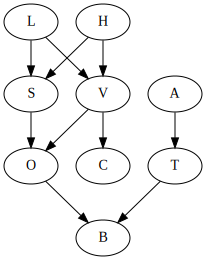

In [9]:
# we use graphviz.Digraph to quickly plot the independence graph.
# It's not the topic of this tutorial, but it's handy
# https://graphviz.readthedocs.io/en/stable/

dot = Digraph(comment='ICU Diagnostic graph')

dot.node('H')  # Hypovolemia
dot.node('L')  # Left ventricular failure
dot.node('A')  # Anaphylaxis
dot.node('V')  # Left ventricular endiastolic volume
dot.node('S')  # Stroke Volume
dot.node('T')  # Total peripheral resistance
dot.node('C')  # Central venous pres
dot.node('O')  # Cardiac output
dot.node('B')  # Blood pressure

dot.edges(['HS', 'HV', 'LS', 'LV', 'VO', 'SO', 'VC', 'AT', 'TB', 'OB'])

dot


If you have problems with the above code (Digraph), do not worry about it as we use it only to visualize the Bayesian network. You can continue with the tutorial. We will first define a data structure to represent this DAG, 
using the dictionary representation introduced earlier
by setting up some variables to define node parents,
and we will define an extra dictionary to record the different possible values each node can take.

**Pro tip**: You can experience weird bugs if you are not careful with the order in which you define your variables in their graph. Python `set` and `dict` objects do not maintain orders for their elements. `list` and `tuple` object do maintain order. Since it's convenient to access the dictionary of variables in a consistent order, we use `OrderedDict` (`odict`) objects to maintain the dictionary in order.

In [12]:
# possible outcomes, by variable
node_outcome_spaces = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)
# DAG representation
# We use an ordered dictionary, `odict`
# because it lets us maintain topological ordering, which lets us be lazy later.
node_parents = odict()
node_parents['H'] = []
node_parents['A'] = []
node_parents['L'] = []
node_parents['V'] = ['H', 'L']
node_parents['S'] = ['H', 'L']
node_parents['T'] = ['A']
node_parents['C'] = ['V']
node_parents['O'] = ['V', 'S']
node_parents['B'] = ['O', 'T']

Now we estimate parameters by ML, by constructing joint distributions for each node in our graph.
This task is similar to the categorical estimation problem from the last tutorial,
in that we will take the proportions of empirical counts as estimates of the probabilities of the counted outcomes, i.e.
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x},\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N},
$$
and
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x}\mid\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N_\boldsymbol{y}},
$$

where $N_{\boldsymbol{x}, \boldsymbol{y}}$ is the number of observations of that outcome,
$$N_{\boldsymbol{x}, \boldsymbol{y}}:=\sum_i\boldsymbol{X_i}=\boldsymbol{x}\cap\boldsymbol{Y_i}=\boldsymbol{y},$$ and $N$ is the total number of observations.



Below is another helper function. This will calculate joint occurrence probability tables.
you invoke it like this
```
prob_table = est_prob_table(data, 'V', (0,1), ['H', 'L'], ((0,1), (0,1)))
```
to estimate all conditional occurrence probabilities of $V|H,L$, where each variable has state space $\{0,1\}$.

In [45]:
def est_prob_table(data, var_name, var_outcomes, parent_names, parent_outcomes):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `var_outcomes`, a tuple of possible outcomes for the conditiona varible and
    `parent_names`, a tuple of columns to be used for the parens and
    `parent_outcomes` a tuple of all possible parent outcomes 
    Return a dictionary containing an estimated conditional probability table.
    """    
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = all_equal_this_index(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            cond_array.append((var_index & parent_index).sum()/parent_index.sum())
        prob_table[parent_combination] = np.asarray(cond_array)
            
    return prob_table

## Exercise
Use the above function to calculate probability tables for all 9 variables in our DAG (Bayesian network structure in the theory part of the tutorial). Store them in a dictionary called `cond_tables_ml`.
Does this recover the conditional distribution that you expect?

In [50]:
def est_helper(data):
    prob_table = odict()

    for i in var_name:
        var_outcomes = node_outcome_spaces[i]
        parent_names = node_parents[i]
        parent_outcomes = [node_outcome_spaces[j] for j in parent_names]
        prob_table[i] = est_prob_table(data, i, var_outcomes, parent_names, parent_outcomes)
    return prob_table
        
cond_tables_ml = est_helper(data)
print(cond_tables_ml)


OrderedDict([('H', OrderedDict([((), array([ 0.801,  0.199]))])), ('L', OrderedDict([((), array([ 0.95,  0.05]))])), ('A', OrderedDict([((), array([ 0.996,  0.004]))])), ('V', OrderedDict([((0, 0), array([ 0.04479578,  0.95520422])), ((0, 1), array([ 0.,  1.])), ((1, 0), array([ 0.9947644,  0.0052356])), ((1, 1), array([ 1.,  0.]))])), ('S', OrderedDict([((0, 0), array([ 0.03820817,  0.96179183])), ((0, 1), array([ 0.95238095,  0.04761905])), ((1, 0), array([ 0.47643979,  0.52356021])), ((1, 1), array([ 1.,  0.]))])), ('T', OrderedDict([((0,), array([ 0.30722892,  0.69277108])), ((1,), array([ 1.,  0.]))])), ('C', OrderedDict([((0,), array([ 0.93965517,  0.04310345,  0.01724138])), ((1,), array([ 0.01822917,  0.26302083,  0.71875   ]))])), ('O', OrderedDict([((0, 0), array([ 0.97029703,  0.00990099,  0.01980198])), ((0, 1), array([ 0.22137405,  0.76335878,  0.01526718])), ((1, 0), array([ 0.7761194 ,  0.19402985,  0.02985075])), ((1, 1), array([ 0.00285307,  0.0085592 ,  0.98858773]))]

In [62]:
cond_tables_ml['B']

OrderedDict([((0, 0), array([ 1.,  0.,  0.])),
             ((0, 1), array([ 0.30081301,  0.61788618,  0.08130081])),
             ((1, 0), array([ 0.92682927,  0.07317073,  0.        ])),
             ((1, 1), array([ 0.01265823,  0.49367089,  0.49367089])),
             ((2, 0), array([ 0.90047393,  0.08056872,  0.01895735])),
             ((2, 1), array([ 0.00409836,  0.07786885,  0.91803279]))])

# Conditional probabilities by naïve summation

We are interested in calculating the conditional distributions.
For the moment we will attempt to find the conditional distribution
$p(L\mid C=\text{high})$.



We will compute $p(L\mid C=\text{high})$ by naïve summation.
How many arithmetic operations does this require?

To do this, we will need to reconstruct each of the joint probabilities from our graph.
Remember that we know that we know a factorization for the joint probabilities,
specifically,

$$p(B,T,O,C,V,S,H,L,A)=p(B\mid O,T)p(T\mid A)p(O\mid V,S)p(C\mid V)p(V\mid H,L)p(S\mid H,L)p(H)p(L)p(A)$$

So we can write a function like this:

In [59]:
def p_joint(B,T,O,C,V,S,H,L,A, cond_tables=cond_tables_ml):
    p = p_cond(cond_tables['B'], B, O, T)
    p *= p_cond(cond_tables['T'], T, A)
    p *= p_cond(cond_tables['O'], O, V, S)
    p *= p_cond(cond_tables['C'], C, V)
    p *= p_cond(cond_tables['S'], S, H, L)
    p *= p_cond(cond_tables['V'], V, H, L)
    p *= p_cond(cond_tables['H'], H)
    p *= p_cond(cond_tables['L'], L)
    p *= p_cond(cond_tables['A'], A)
    return p

# import copy
# def nested_loop_all(dic1, used, number):
#     dic = copy.deepcopy(dic1)
#     dic['C'] = 1
#     dic['L'] = 0
#     if used >= len(dic) - 3:
#         return p_joint(dic['B'], dic['T'], dic['O'], dic['C'], 
#                        dic['S'], dic['V'], dic['H'], dic['L'],
#                        dic['A'])
#     temp = 0
#     for i in dic:
#         if temp < used:
#             temp += 1
#             continue
#         for j in node_outcome_spaces[i]:
#             if (i == "C" and j != 1) or (i == 'L' and j != 0):
#                 return 0
#             dic[i] = j
#             number += nested_loop_all(dic, used + 1, number)
#     return number    
# a = copy.deepcopy(node_outcome_spaces)
# print(nested_loop_all(a, 0, 0))



for i in node_outcome_spaces:
    for j in node_outcome_spaces[i]:
        

RuntimeError: dictionary changed size during iteration

## Exercise
Compute $p(L\mid C=\text{high})$ by naïve summation and count the number of additions required.
Use `p_joint` and `node_outcome_spaces`.

In [25]:
node_names = node_outcome_spaces.keys()
all_outcome_combinations = product(*node_outcome_spaces.values())

p_l1_and_c2 = 0.0
p_c2 = 0.0
n_ops = 0

## Your code here

# Conditional probabilities by variable elimination

## Exercise
Recall our factorisation of the distribution
$$p(B,T,O,C,V,S,H,L,A)=p(B\mid O,T)p(T\mid A)p(O\mid V,S)p(C\mid V)p(V\mid H,L)p(S\mid H,L)p(H)p(L)p(A)$$

Use variable elimination to implement an efficient version of the calculation of
$p(L\mid C=\text{high}),$ and count how many additions of conditional probabilities you require.


# Sampling from a Bayesian network
Here we are interested in generating samples from our Bayesian network. A very simple method is _ancestral sampling_ ( See for example Barber section 27.2), where one first samples from nodes without parents and then continues down the network sampling from nodes given the samples from their parents. 

To sample from a Bayesian network with categorical variables, we first define a useful function to simulate from a categorical distribution, given the corresponding probabilities.

In [18]:
def wchoose(theta):
    """
    sample rv whose value is one of several categories, with probabilites given by theta
    (returns *index* of category chosen, e.g. `2`, not `[0,0,1]`.)
    
    (Providing the probability of the last category is optional, since it is determined by the others.)
    """
    r = random()
    cumsum = 0.0
    i = 0
    for p in theta:
        cumsum += p
        if cumsum > r:
            return i
        i += 1
    return i


## Exercise

* Write a program that estimates $p(L\mid C=2)$ using ancestral sampling to sample from the required distribution.
* Use 1000 samples, and compare your estimate with the previous calculations.
* Now repeat the sampling procedure with different numbers of samples, and analyze estimates as a function of number of samples.



# Conditional independence
Here we numerically estimate conditional independences.

Here is useful function for the following question, to marginalise the distribution by brute-force summation.

In [19]:
def p_marginalize(cond_tables=cond_tables_ml, **evidence):
    """
    Calculate a joint probability by naïvely summing over margins.
    For large graphs this is simply too inefficient, but it's OK for us.
    
    >>> p_marginalize(H=0, L=0) + p_marginalize(H=0, L=1) + \
        p_marginalize(H=1, L=0) + p_marginalize(H=1, L=1)
    1.0
    >>> p_marginalize(H=0, C=0) + p_marginalize(H=0, C=1) + \
        p_marginalize(H=0, C=2) + p_marginalize(H=1, C=0) + \
        p_marginalize(H=1, C=1) + p_marginalize(H=1, C=2)
    1.0
    """
    nuisance_vars = list(node_outcome_spaces.keys())
    
    for node in evidence.keys():
        nuisance_vars.pop(nuisance_vars.index(node))
    
    marginal = 0.0
    for outcomes in product(*[
            node_outcome_spaces[node] for node in nuisance_vars
        ]):
        var_values = dict(zip(nuisance_vars, outcomes))
        var_values.update(evidence)
        marginal += p_joint(**var_values)
    return marginal



NameError: name 'cond_tables_ml' is not defined

## Exercise
- Show or refute  the conditional independences in the theory tutorial numerically. i.e. 
determine whether

1. $H \indep L$
2. $H \indep A$
3. $C \indep L$
4. $C \indep L\mid B$
